# Overview
Currently, there are no overarching measurements of the performance of the parking demand model taking place in this repository. To inform conversations about the accuracy of the model, we should develop a testing methodology and use it to record performance metrics for the current (and future) model.

The outcome of this work should be a notebook in which our testing approach is clearly documented and applied to the current model. Said documentation should include

- [ ] which metrics are being tracked (e.g., MAE & MAPE, forecast bias, etc.)
- [ ] the testing strategy at play (e.g., variants of out-of-sample/holdout, prequential, and cross-validation)

and our motivation for the choices made in our testing approach. This or a separate notebook should also include

- [ ] metric values for the current production model and
- [ ] relevant visualizations

based on parking zones, times of day, etc.

# Proposed Testing Methodology
As a quick first pass, we suggest the following simple testing methodology.

## Assumptions
1. The parking zones in operation for at least one year prior to the COVID-19 pandemic can serve as a representative sample of all parking zones for which predictions are desired, past and present.
2. ParkColumbus will only be fetching same-day parking predictions.
3. Training will occur once a day in the evening.

## Methodology
We will restrict to a subset `data` of the dataset consisting of the records
- from 2018-09-17 (a Monday) to 2019-09-27 (a Saturday)
- for all zones that existed and continuously reported transaction data throughout that time period.

Beginning with a date `start_date` ranging from the first Monday (2018-09-17) and continuing through the first Saturday (2018-09-22) with records in `data`, we will proceed as follows:
1. Train a fresh instance of the model under test using all records in `data` between `start_date` at 8:00 AM (inclusive) and `end_date` at 10:00 PM (exclusive), where `end_date` is the day $7 \cdot 53 - 1 = 370$ days after `start_date`.
  - $370$ days is chosen so that the training dataset (a) contains the same number of each day of the week, (b) contains at least one year of data, and (c) ends on the day of the week preceding `start_date`'s day of the week
  - For instance, when `start_date` is Tuesday, September 18th, 2018, the training dataset will end with the data from Monday, September 23rd, 2019.
2. Request predictions from this newly-trained model for all half hour intervals between 8:00 AM and 10:00 PM the day after `end_date`, for each zone in `data`.
3. Compute the **mean absolute error** (**MAE**) and **seasonal scaled mean absolute scaled error** (**sMASE**) by zone and half hour interval.
  - When calculating the MAE and sMASE, one should compute the residuals at every half hour time step during the test date from 8:00–8:30 AM to 9:30–10:00 PM.
  - When computing sMASE values by zone, a seasonality lag of
  
    $$
        \langle\text{daily half-hour operating periods}\rangle
        \cdot \langle\text{days in operation per week}\rangle
        =
        28 \cdot 6
    $$
    
    should be assumed.

## Discussion
Note that neither of the metrics we are using are particularly traditional in the time series space, but arise due to our nightly training procedure. Since we are only training each evening (rather than in an online manner throughout the day), using traditional forecasting errors $e_t = y_t - \hat{y}_{t | t - 1}$ would give us a skewed (and, likely, inflated) picture of the performance of our forecasts. As such, we calculate the MAE and sMASE for not one step ahead but the next $28$ steps (full day) in each zone.

The COVID-19 pandemic resulted in a drastic reduction in commuters and shoppers in high-traffic areas of Columbus, and most of the parking demand data from 2020 is wildly different than the data from 2018–2019 accordingly. It also is reasonable to assume that post-pandemic data will be closer aligned to pre-pandemic data than in-pandemic data. By restricting to 2018–2019 data when evaluating models, we obtain a much more realistic picture of how capable our models will be at predicting demand in the future.

This approach is, unfortunately, not without limitations. When enough data is available, it will be useful to evaluate how the model performs on similar tests season-by-season or month-by-month. With the current data, we might at very least include similar evaluations with prediction dates chosen from the months of October 2019 through February 2020, but we've omitted this sort of test due to limited time constraints.

We are also only evaluating high-level, easily interpretable metrics for models (so that the resulting number are easily explained to business stakeholders). This leaves room for additional metrics being needed to justify the use of a new model architecture over an old one (such as a variant of forecast error/bias, residual autocorrelation measures, etc.). We leave that problem to the intrepid data scientist of the future who continues to upgrade these models.

# Preparing the Environment

In [2]:
import datetime as dt
import os
from dataclasses import dataclass
from pathlib import Path

import git
import numpy as np
import pandas as pd
import pyodbc
from sktime.forecasting.model_selection import temporal_train_test_split
from sqlalchemy import create_engine
from tqdm.notebook import tqdm

REPO_ROOT = Path(git.Repo('.', search_parent_directories=True).working_tree_dir).absolute()
OCCUPANCY_FEATHER_PATH = REPO_ROOT / 'data' / 'raw' / 'parking_zone_occupancy_aggr.feather'

%cd -q $REPO_ROOT

import app.keeper_of_the_state
from app.constants import DAY_OF_WEEK
from app.constants import UNENFORCED_DAYS
from app.data_formats import APIPredictionRequest
from app.model import ModelFeatures, ParkingAvailabilityModel

# Retrieving Production Dataset

In [3]:
if OCCUPANCY_FEATHER_PATH.exists():
    occupancy = pd.read_feather(OCCUPANCY_FEATHER_PATH)
else:
    occupancy = pd.read_sql_query(
        r'''
            SELECT *
            FROM [dbo].[parking_zone_occupancy_aggr]
            ORDER BY zone_name, semihour
        ''',
        'mssql+pyodbc://{user}:{password}@{server_url}:{server_port}/{database}?driver={driver}'.format(
            user='padmin',
            password=os.getenv('SQL_SERVER_PASSWORD'),
            server_url='dev-data-science-parking-prediction.crrvm15jali6.us-west-2.rds.amazonaws.com',
            server_port='1433',
            database='parking_prediction',
            driver='ODBC+Driver+17+for+SQL+Server'
        )
    )
    occupancy.to_feather(OCCUPANCY_FEATHER_PATH)

This results in a rather hefty `DataFrame`.

In [4]:
occupancy.info(null_counts=True, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16006949 entries, 0 to 16006948
Data columns (total 14 columns):
 #   Column                Non-Null Count     Dtype         
---  ------                --------------     -----         
 0   zocc_id               16006949 non-null  int64         
 1   zone_name             16006949 non-null  object        
 2   semihour              16006949 non-null  datetime64[ns]
 3   occu_min              16006949 non-null  float64       
 4   occu_mtr_cnt          16006949 non-null  int64         
 5   no_trxn_one_day_flg   16006949 non-null  int64         
 6   no_trxn_one_week_flg  16006949 non-null  int64         
 7   load_on               16006949 non-null  datetime64[ns]
 8   total_cnt             16006949 non-null  int64         
 9   occu_min_rate         16006949 non-null  float64       
 10  occu_cnt_rate         16006949 non-null  float64       
 11  city_holiday          389424 non-null    object        
 12  shortnorth_event      0 no

## Applying Business Rules
While model-specific dataset transformations are confined to model implementations (in `app/model.py`), two dataset invariants that are operations-specific are enforced in `train.py` before data is passed into a new model:

1. Parking meters at which no transactions have occurred for a week are removed.
2. Records for times more than 30 minutes before/after the hours of operation for parking meters are removed.

Both of these filters are reasonable to apply when evaluating a model's performance, as well.

In [5]:
def remove_unoccupied_timeslots(occupancy_dataframe: pd.DataFrame) -> pd.DataFrame:
    return occupancy_dataframe.loc[(
        (occupancy_dataframe.no_data != 1)
      & (occupancy_dataframe.no_trxn_one_week_flg != 1)
    )]


def remove_times_outside_hours_of_operation(occupancy_dataframe: pd.DataFrame) -> pd.DataFrame:
    enforcement_days = [day.value for day in DAY_OF_WEEK
                        if day not in UNENFORCED_DAYS]
    return (
        occupancy_dataframe
            .set_index('semihour')
            .between_time('08:00', '22:00', include_end=False)
            .reset_index()
            .loc[lambda df: df.semihour.dt.dayofweek.isin(enforcement_days), :]
    )


occupancy = (occupancy.rename(columns={'zone_name': 'zone_id'})
                      .pipe(remove_unoccupied_timeslots)
                      .pipe(remove_times_outside_hours_of_operation))

Given the hours of operation of Columbus parking meters, it's unsurprising that this roughly halves the amount of data in our dataset.

In [6]:
occupancy.info(null_counts=True, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6506324 entries, 532 to 7615400
Data columns (total 14 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   semihour              6506324 non-null  datetime64[ns]
 1   zocc_id               6506324 non-null  int64         
 2   zone_id               6506324 non-null  object        
 3   occu_min              6506324 non-null  float64       
 4   occu_mtr_cnt          6506324 non-null  int64         
 5   no_trxn_one_day_flg   6506324 non-null  int64         
 6   no_trxn_one_week_flg  6506324 non-null  int64         
 7   load_on               6506324 non-null  datetime64[ns]
 8   total_cnt             6506324 non-null  int64         
 9   occu_min_rate         6506324 non-null  float64       
 10  occu_cnt_rate         6506324 non-null  float64       
 11  city_holiday          58281 non-null    object        
 12  shortnorth_event      0 non-null        

# Restricting to Data within Testing Range

## Generating Training and Testing Time Bounds

In [7]:
TRAINING_WEEKS = 53


def training_end_offset(number_of_weeks=TRAINING_WEEKS, with_hours=True):
    offset_arguments = {'days': 7 * number_of_weeks - 1}
    if with_hours:
        offset_arguments['hours'] = 22
    return pd.DateOffset(**offset_arguments)


def training_bounds(start_date, number_of_weeks=TRAINING_WEEKS):
    start_date = pd.Timestamp(start_date).normalize()
    start_timestamp = start_date + pd.DateOffset(hours=8)
    end_timestamp = start_date + training_end_offset(number_of_weeks) - pd.Timedelta('1 nanosecond')
    return start_timestamp, end_timestamp


def testing_bounds(training_start_date, training_weeks=TRAINING_WEEKS):
    training_end_date = training_bounds(training_start_date, number_of_weeks=training_weeks)[1]
    testing_end_date = training_end_date + pd.DateOffset(days=1)
    testing_start_date = testing_end_date.normalize() + pd.DateOffset(hours=8)
    return testing_start_date, testing_end_date


example_first_day = '2018-09-17'
example_first_day_ts = pd.Timestamp(example_first_day)

example_train_start, example_train_end = training_bounds(example_first_day)
example_test_start, example_test_end = testing_bounds(example_first_day)

assert example_first_day_ts.normalize() == example_train_start.normalize()
assert (example_train_end - example_train_start).days == 7 * TRAINING_WEEKS - 1
assert example_train_start.day_name() == (example_train_end + pd.DateOffset(days=1)).day_name()
assert example_test_start.normalize() == example_train_end.normalize() + pd.DateOffset(days=1)
assert example_test_start.normalize() == example_test_end.normalize()

<ipython-input-7-39f80e832ced>:29: UserWarning: Discarding nonzero nanoseconds in conversion
  example_test_start, example_test_end = testing_bounds(example_first_day)
/Users/daniel.r.moore/Library/Caches/pypoetry/virtualenvs/predictive-parking-J8Xdfjko-py3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: UserWarning: Discarding nonzero nanoseconds in conversion
  exec(code_obj, self.user_global_ns, self.user_ns)


## Restricting `occupancy` to the Training & Testing Period

In [107]:
TRAINING_START_DATES = [f'2018-09-{day}' for day in range(17, 23)]

EARLIEST_TRAINING_DATETIME = training_bounds(TRAINING_START_DATES[0])[0]
LATEST_TESTING_DATETIME = testing_bounds(TRAINING_START_DATES[-1])[1]

occupancy = occupancy[occupancy.semihour.between(EARLIEST_TRAINING_DATETIME, LATEST_TESTING_DATETIME)]

<ipython-input-107-d63922083768>:4: UserWarning: Discarding nonzero nanoseconds in conversion
  LATEST_TESTING_DATETIME = testing_bounds(TRAINING_START_DATES[-1])[1]


## Generating Training and Testing Datasets

In [94]:
def zones_spanning_period(df, start_date, end_date, zone_column='zone_id', timestamp_column='semihour',
                          eps=pd.Timedelta(minutes=30)):
    '''
    Returns all zones in `df` with records from `start_date` to `end_date`
    (inclusive).
    
    Zones are admitted if they are associated with records within `eps` of both
    bounds (exclusive).
    '''
    zone_is_admissible = (
        (df.groupby(zone_column)[timestamp_column].min() - start_date < eps) &
        (end_date - df.groupby(zone_column)[timestamp_column].max() < eps)
    )
    return zone_is_admissible[zone_is_admissible].index


def training_and_testing_data(df, training_start_date, timestamp_column='semihour', zone_column='zone_id'):
    training_start, training_end = training_bounds(training_start_date)
    testing_start, testing_end = testing_bounds(training_start_date)

    train_data = df[df[timestamp_column].between(training_start, training_end)]
    test_data = df[df[timestamp_column].between(testing_start, testing_end)]

    zones_under_test = zones_spanning_period(
        df, training_start, testing_end,
        timestamp_column=timestamp_column, zone_column=zone_column
    )

    return (
        train_data[train_data[zone_column].isin(zones_under_test)],
        test_data[test_data[zone_column].isin(zones_under_test)]
    )


example_train, example_test = training_and_testing_data(occupancy, example_first_day)

assert example_train.semihour.min() == example_train_start
assert (
    example_train_end - example_train.semihour.max() <= pd.Timedelta(minutes=30)
    or (
        example_train_end - example_train.semihour.max() <= pd.Timedelta(days=1, minutes=30)
        and example_train_start.day_name() == 'Monday'
    )
)

assert example_test.semihour.min() == example_test_start
assert example_test_end - example_test.semihour.max() < pd.Timedelta(minutes=30)

<ipython-input-94-00cd7e062453>:19: UserWarning: Discarding nonzero nanoseconds in conversion
  testing_start, testing_end = testing_bounds(training_start_date)


## Restricting to zones present in 2018–2019

In [102]:
ALL_ZONES_UNDER_TEST = zones_spanning_period(occupancy, EARLIEST_TRAINING_DATETIME, LATEST_TESTING_DATETIME)

occupancy = occupancy[occupancy.zone_id.isin(ALL_ZONES_UNDER_TEST)]

# Testing the Current Production Model

## Generating Model Features
Our current production model takes in a parking zone ID and one-hot encoded variables representing the "semihour" (half hour interval) of operation and day of the week for the prediction request. Training is performed using _availability_ – as opposed to _occupancy_ – rates as predicted values.

In [103]:
occupancy = occupancy.assign(
    available_rate=lambda df: 1 - df.occu_cnt_rate,
    dayofweek=lambda df: df.semihour.dt.dayofweek.astype('category'),
    semihour_tuples=lambda df: pd.Series(
        zip(df.semihour.dt.hour, df.semihour.dt.minute),
        dtype='category', index=df.index
    )
)

semihour_onehots = pd.get_dummies(occupancy.semihour_tuples, drop_first=True)
dayofweek_onehots = pd.get_dummies(occupancy.dayofweek, drop_first=True)

## Generating Residuals for Zones Under Test

In [459]:
data_by_zone = {
    zone_id: [
        subset.index
        for subset in temporal_train_test_split(
            occupancy[occupancy.zone_id == zone_id],
            train_size=training_records_count, test_size=test_records_count
        )
    ]
    for zone_id in tqdm(ALL_ZONES_UNDER_TEST)
}

In [461]:
train_index = pd.Int64Index([])
for train_idx, _ in tqdm(list(initial_splits.values())):
    train_index = train_index.union(train_idx)

test_zones = occupancy.loc[train_index].zone_id.unique()
test_index_single_zone = list(initial_splits.values())[0][1]

## Training models for each day of operation

In [108]:
models_by_day = {}
test_sets_by_day = {}

for training_start_date in tqdm(TRAINING_START_DATES):
    models_by_day[training_start_date] = ParkingAvailabilityModel()
    train, test_sets_by_day[training_start_date] = training_and_testing_data(occupancy, training_start_date)

    models_by_day[training_start_date].train(train)

<ipython-input-94-00cd7e062453>:19: UserWarning: Discarding nonzero nanoseconds in conversion
  testing_start, testing_end = testing_bounds(training_start_date)


KeyboardInterrupt: 

# Test

In [463]:
test_timestamps = occupancy.loc[test_index_single_zone].semihour

assert len(test_index_single_zone) == test_records_count

test_semihour_onehots = semihour_onehots.loc[test_index_single_zone]
test_dayofweek_onehots = dayofweek_onehots.loc[test_index_single_zone]

In [464]:
import itertools

from tqdm.notebook import tqdm

In [473]:
test_results = pd.Series(
    index=pd.MultiIndex.from_product([
        test_timestamps,
        test_zones
    ]),
    name='prediction',
    dtype='float64'
)

for zone_id, (timestamp, semihour_onehot, dayofweek_onehot) in tqdm(
    itertools.product(
        test_zones,
        zip(
            test_timestamps,
            test_semihour_onehots.itertuples(index=False),
            test_dayofweek_onehots.itertuples(index=False)
        )
    ),
    total=len(test_timestamps) * len(test_zones)
):
    test_results.loc[(timestamp, zone_id)] = model.predict(
        [
            ModelFeatures(
                zone_id=zone_id,
                semihour_onehot=semihour_onehot,
                dayofweek_onehot=dayofweek_onehot
            )
        ]
    )[zone_id]

In [467]:
test_actual = occupancy.loc[
    occupancy.semihour.isin(test_timestamps) &
    occupancy.zone_id.isin(test_zones),
    ['semihour', 'zone_id', 'occu_cnt_rate']
].set_index(['semihour', 'zone_id']).occu_cnt_rate.sort_index()

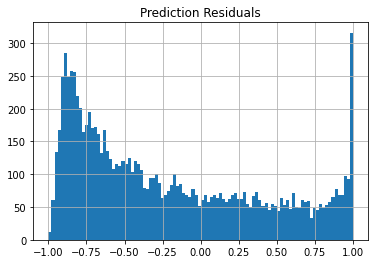

In [468]:
test_residuals = test_actual - test_results[test_actual.index]
test_residuals.hist(bins=100).set_title('Prediction Residuals');

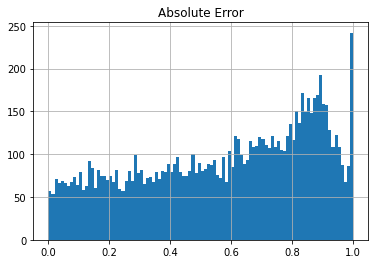

In [469]:
test_residuals.abs().hist(bins=100).set_title('Absolute Error');

Text(0.5, 1.06, 'Distribution of Zone Availability Residuals $\\hat{y}_z - y_z$\nfor Monday, 2019-11-25')

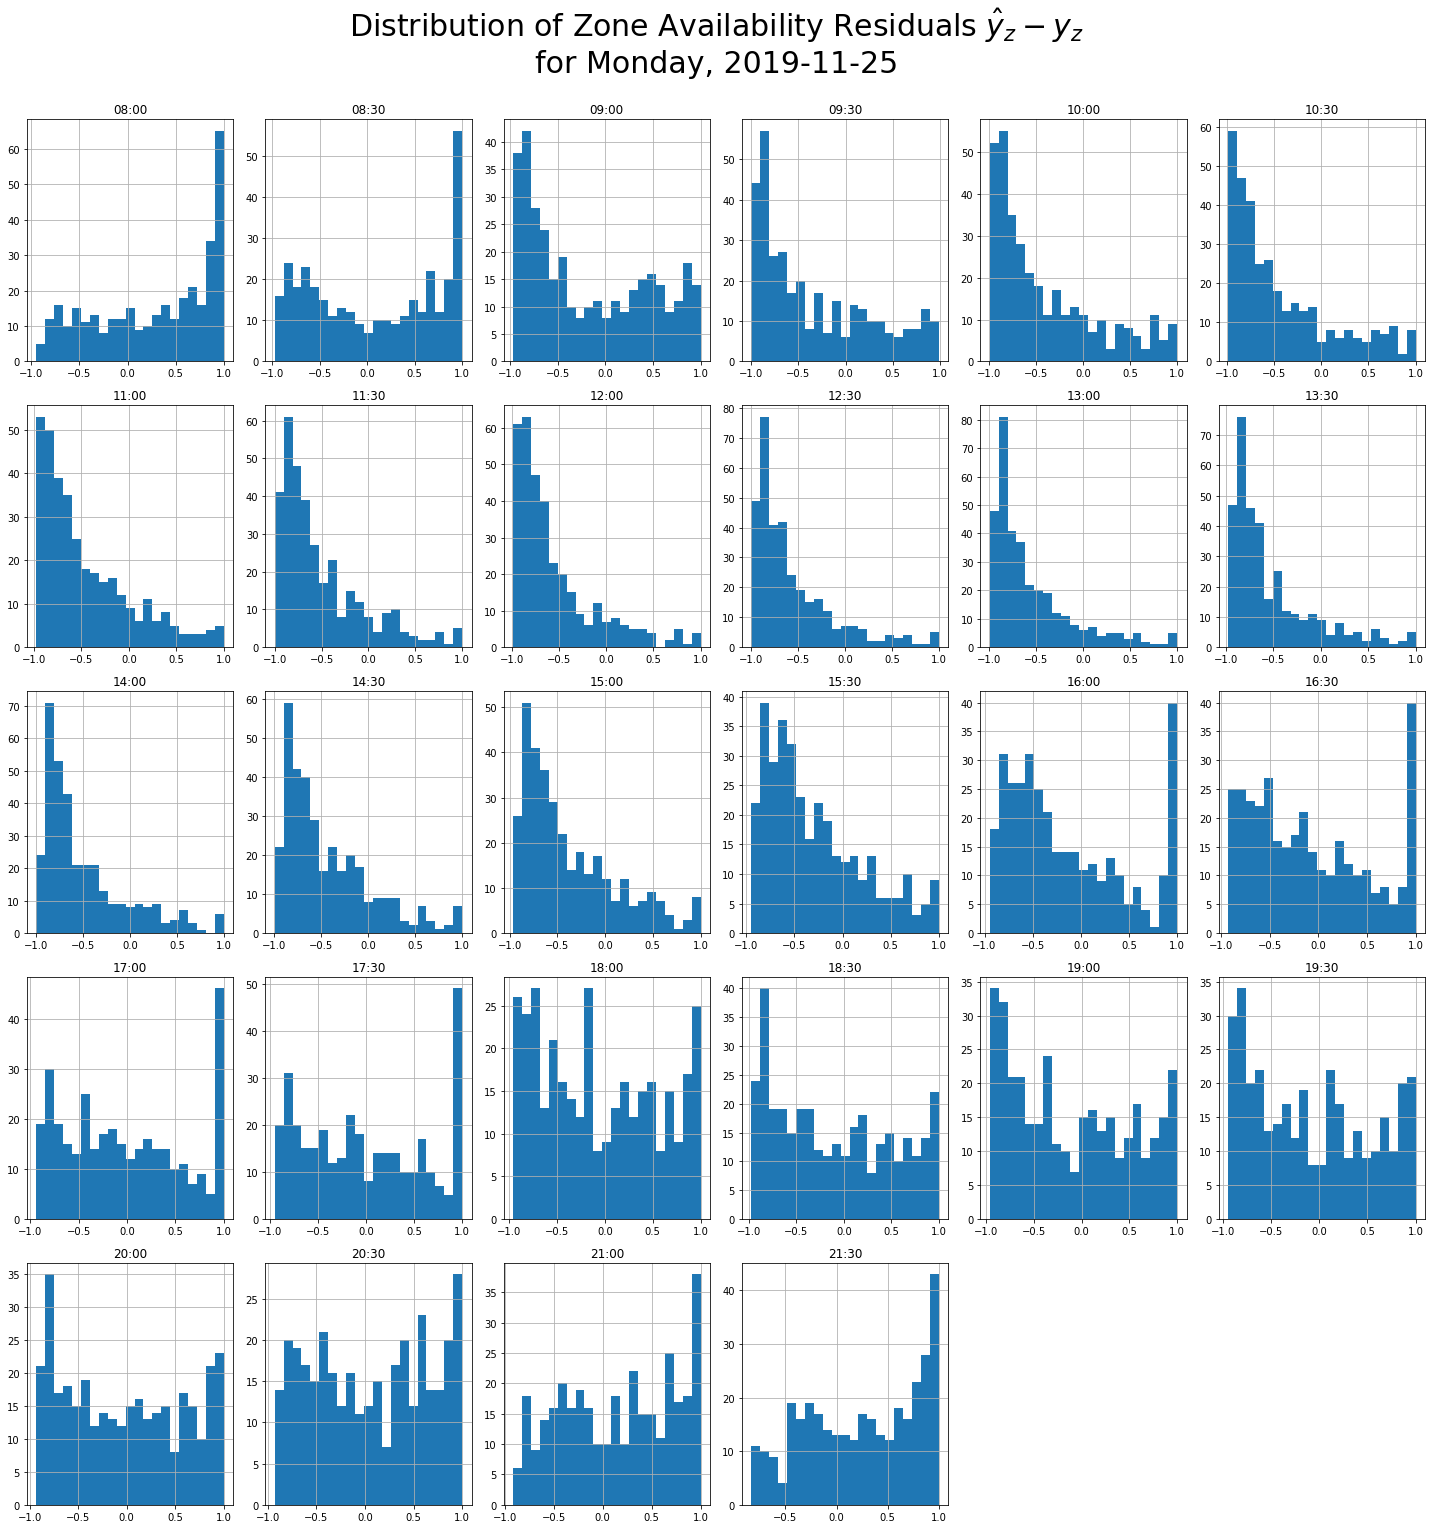

In [529]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 6, figsize=(20, 20))

for index, (semihour, group) in enumerate(test_residuals.groupby('semihour')):
    ax = axes[index // 6][index % 6]
    group.hist(ax=ax, bins=21).set_title(str(semihour.time())[:-3])

for remaining_ax_idx in range(index + 1, 30):
    axes[remaining_ax_idx // 6][remaining_ax_idx % 6].axis('off')

fig.tight_layout()
fig.suptitle(f'Distribution of Zone Availability Residuals $y_z - \hat{{y}}_z$\nfor {semihour.day_name()}, {semihour.date()}', x=0.5, y=1.06, fontsize=30)

# Performance Measures
## MAE

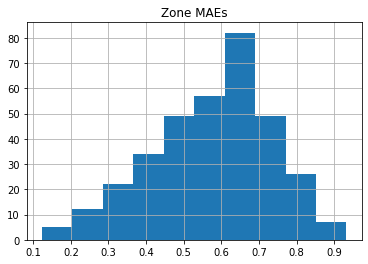

In [530]:
test_residuals[test_actual.index].unstack().abs().mean(axis='index').hist().set_title('Zone MAEs');

In [498]:
print('Overall MAE:', test_residuals[test_actual.index].abs().mean())
test_residuals[test_actual.index].unstack().abs().mean(axis='index')

Overall MAE: 0.5757004966948226


zone_id
17012    0.639983
17013    0.569390
17014    0.749552
17015    0.709666
17016    0.326592
           ...   
72056    0.262928
72057    0.612856
72058    0.645895
72059    0.463969
72060    0.430194
Length: 343, dtype: float64